In [36]:
import numpy as np

In [37]:
TEST_LINE = np.array([[-2.980674, 2.4316025, 0.],
 [ 1.9609697,-0.7843879,0.],
 [ 1.0197042,-0.7843879,0.],
 [ 0.86282665,-0.7843879,0.],
 [ 0.6275103,-0.86282665,0.]])


In [38]:
models_root_dir = 'models/'
model_dir = 'models/images'

In [39]:
from sketch_rnn.sketch_rnn_train import *
from sketch_rnn.model import *
from sketch_rnn.utils import *
from sketch_rnn.rnn import *

In [40]:
model_params, eval_model_params, sample_model_params = load_model(model_dir)

In [41]:
tf.compat.v1.disable_eager_execution()
reset_graph()
model = Model(model_params)
eval_model = Model(eval_model_params, reuse=True)
sample_model = Model(sample_model_params, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [42]:
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

In [43]:
load_checkpoint(sess, model_dir)

models/images
INFO:tensorflow:Loading model models/images/vector-5000.
INFO:tensorflow:Restoring parameters from models/images/vector-5000


In [44]:
import tensorflow as tf
import svgwrite
from IPython.display import SVG, display
from six.moves import xrange

# little function that displays vector images and saves them to .svg
def draw_strokes2(data, factor=0.2, svg_filename = 'sample.svg', c="black"):
#   tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    out = '<svg xmlns="http://www.w3.org/2000/svg" version="1.1">'
    temp = []
    for d in data:
        p = d.copy()
        p[0]/=factor
        p[1]/=factor
        temp.append([p[0], p[1]])
        if p[2] == 1.0 and len(temp) > 0:
            l = ",".join([str(p[0]*0.5)+","+str(p[1]*0.5) for p in temp])
            temp = []
    l = ",".join([str(p[0]*0.5)+","+str(p[1]*0.5) for p in temp])
    out += '<polyline points="'+l+f'" stroke="black" stroke-width="0.5" fill="none" />\n'
    out += '</svg>'
    return out
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
def draw_strokes(data, factor=0.2, svg_filename = 'sample.svg', c="black"):
#   tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = c
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  print(dwg.tostring())
  display(SVG(dwg.tostring()))
  return dwg

<svg baseProfile="full" height="66.07995175" version="1.1" width="72.35505425" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="white" height="66.07995175" width="72.35505425" x="0" y="0" /><path d="M39.903369999999995,28.921939250000005 m-14.903369999999999,12.158012499999998 l9.804848499999999,-3.9219395 5.098521,-3.9219395 l4.31413325,-3.9219395 3.1375515,-4.31413325 " fill="none" stroke="black" stroke-width="1" /></svg>


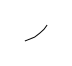

In [45]:
dwg = draw_strokes(TEST_LINE)

In [46]:
print(svgwrite.shapes.Polyline(dwg.elements[2]))

KeyError: 0

In [ ]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes,max_len=eval_model.hps.max_seq_len).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  print(seq_len)
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0], strokes

z, stks = encode(TEST_LINE)

In [ ]:
def pad_batch(model, batch, max_len):
    """Pad the batch to be stroke-5 bigger format as described in paper."""
    start_stroke_token = [0, 0, 1, 0, 0]
    result = np.zeros((model.hps.batch_size, max_len + 1, 5), dtype=float)
    assert len(batch) == model.hps.batch_size
    for i in range(model.hps.batch_size):
        l = len(batch[i])
        assert l <= max_len
        result[i, 0:l, 0:2] = batch[i][:, 0:2]
        result[i, 0:l, 3] = batch[i][:, 2]
        result[i, 0:l, 2] = 1 - result[i, 0:l, 3]
        result[i, l:, 4] = 1
        # put in the first token, as described in sketch-rnn methodology
        result[i, 1:, :] = result[i, :-1, :]
        result[i, 0, :] = 0
        result[i, 0, 2] = start_stroke_token[2]  # setting S_0 from paper.
        result[i, 0, 3] = start_stroke_token[3]
        result[i, 0, 4] = start_stroke_token[4]
    return result

def sample(sess, model, seq_len=250, temperature=1.0, greedy_mode=False,
           z=None, stks=None):
  """Samples a sequence from a pre-trained model."""

  def adjust_temp(pi_pdf, temp):
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf

  def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    """Samples from a pdf, optionally greedily."""
    if greedy:
      return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
      accumulate += pdf[i]
      if accumulate >= x:
        return i
    tf.logging.info('Error with sampling ensemble.')
    return -1

  def sample_gaussian_2d(mu1, mu2, s1, s2, rho, temp=1.0, greedy=False):
    if greedy:
      return mu1, mu2
    mean = [mu1, mu2]
    s1 *= temp * temp
    s2 *= temp * temp
    cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

  prev_x = np.zeros((1, 1, 5), dtype=np.float32)
  prev_x[0, 0, 2] = 1  # initially, we want to see beginning of new stroke

  if z is None:
    z = np.random.randn(1, model.hps.z_size)  # not used if unconditional

  if not model.hps.conditional:
    prev_state = sess.run(model.initial_state)
  else:
    prev_state = sess.run(model.initial_state, feed_dict={model.batch_z: z})

  len_stks = len(stks)  
  strokes = np.zeros((seq_len, 5), dtype=np.float32)
  mixture_params = []

  greedy = greedy_mode
  temp = temperature
  for j,stk in enumerate(stks):
    i = j+1  
    dta = pad_batch(sample_model,np.array([[stk]]),1)
    if not model.hps.conditional:
      feed = {
          model.input_x: prev_x,
          model.sequence_lengths: [1],
          model.initial_state: prev_state,
          model.input_data: dta
      }
    else:
      feed = {
          model.input_x: prev_x,
          model.sequence_lengths: [1],
          model.initial_state: prev_state,
          model.batch_z: z,
          model.input_data: dta
      }

    params = sess.run([
        model.pi, model.mu1, model.mu2, model.sigma1, model.sigma2, model.corr,
        model.pen, model.final_state
    ], feed)

    [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params

    idx = get_pi_idx(random.random(), o_pi[0], temp, greedy)

    idx_eos = get_pi_idx(random.random(), o_pen[0], temp, greedy)
    eos = [0, 0, 0]
    eos[idx_eos] = 1

    next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                          o_sigma1[0][idx], o_sigma2[0][idx],
                                          o_corr[0][idx], np.sqrt(temp), greedy)

    params = [
        o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0],
        o_pen[0]
    ]

    mixture_params.append(params)

    prev_x = np.zeros((1, 1, 5), dtype=np.float32)
    prev_x[0][0] = np.array(
        [next_x1, next_x2, eos[0], eos[1], eos[2]], dtype=np.float32)
    prev_state = next_state

  for i in range(seq_len):
    if not model.hps.conditional:
      feed = {
          model.input_x: prev_x,
          model.sequence_lengths: [1],
          model.initial_state: prev_state
      }
    else:
      feed = {
          model.input_x: prev_x,
          model.sequence_lengths: [1],
          model.initial_state: prev_state,
          model.batch_z: z
      }

    params = sess.run([
        model.pi, model.mu1, model.mu2, model.sigma1, model.sigma2, model.corr,
        model.pen, model.final_state
    ], feed)

    [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params

    idx = get_pi_idx(random.random(), o_pi[0], temp, greedy)

    idx_eos = get_pi_idx(random.random(), o_pen[0], temp, greedy)
    eos = [0, 0, 0]
    eos[idx_eos] = 1

    next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                          o_sigma1[0][idx], o_sigma2[0][idx],
                                          o_corr[0][idx], np.sqrt(temp), greedy)

    strokes[i, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]

    params = [
        o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0],
        o_pen[0]
    ]

    mixture_params.append(params)

    prev_x = np.zeros((1, 1, 5), dtype=np.float32)
    prev_x[0][0] = np.array(
        [next_x1, next_x2, eos[0], eos[1], eos[2]], dtype=np.float32)
    prev_state = next_state
  return strokes, mixture_params

import random
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.1, seq_len=eval_model.hps.max_seq_len):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=seq_len, temperature=temperature, z=z, stks=stks)

  strokes = to_normal_strokes(sample_strokes)
  strokes[-1][2] = 1
  enc_strokes = to_normal_strokes(np.array(stks))

  # print(strokes.shape)
  # print(enc_strokes.shape)
  everything = np.concatenate((strokes,TEST_LINE),0)

  if draw_mode:
    draw_strokes(strokes, factor)
    draw_strokes(TEST_LINE, factor, c="red")
    draw_strokes(everything, factor)
  return strokes


In [49]:
# _ = decode(z, temperature=0.3, seq_len=50, factor=0.2)

In [50]:
# _ = decode(z, temperature=0.3, seq_len=50, factor=0.01)

## Coordinates to stroke3 and back

In [94]:
coord = [[[304.0133779264214, 255.35117056856186],[309.03010033444815, 255.35117056856186], [321.0702341137124, 256.3545150501672], [332.10702341137124, 257.3578595317726], [345.1505016722408, 257.3578595317726], [351.17056856187287, 257.3578595317726], [356.18729096989966, 257.3578595317726], [358.19397993311037, 257.3578595317726], [360.2006688963211, 256.3545150501672], [360.2006688963211, 253.34448160535115], [360.2006688963211, 246.3210702341137], [360.2006688963211, 237.29096989966555], [358.19397993311037, 226.25418060200667], [355.1839464882943, 218.22742474916387], [349.1638795986622, 211.2040133779264], [344.1471571906354, 205.1839464882943], [336.12040133779266, 201.1705685618729], [331.10367892976586, 200.16722408026754], [326.0869565217391, 200.16722408026754], [322.0735785953177, 200.16722408026754], [318.0602006688963, 203.1772575250836], [316.0535117056856, 209.19732441471572], [315.05016722408027, 218.22742474916387], [313.04347826086956, 246.3210702341137], [313.04347826086956, 273.4113712374582], [313.04347826086956, 304.51505016722405], [313.04347826086956, 325.58528428093643], [313.04347826086956, 353.67892976588627], [311.03678929765886, 373.7458193979933], [307.02341137123744, 385.7859531772575], [303.01003344481603, 395.81939799331104], [294.9832775919732, 403.8461538461538], [284.94983277591973, 410.8695652173913], [270.9030100334448, 415.88628762541805], [255.85284280936455, 418.8963210702341], [241.80602006688963, 418.8963210702341], [229.76588628762542, 418.8963210702341], [219.7324414715719, 413.87959866220734], [213.7123745819398, 409.86622073578593], [205.68561872909697, 401.8394648829431], [202.67558528428094, 395.81939799331104], [201.6722408026756, 390.80267558528425], [200.66889632107024, 386.78929765886284], [200.66889632107024, 381.7725752508361], [202.67558528428094, 377.7591973244147], [208.69565217391303, 374.74916387959865], [215.7190635451505, 371.7391304347826], [224.74916387959865, 370.73578595317724], [230.76923076923077, 370.73578595317724], [235.7859531772575, 370.73578595317724], [238.79598662207357, 370.73578595317724], [239.79933110367892, 370.73578595317724]]]

In [97]:
coord = [[[204.68227424749162, 368.72909698996654], [204.68227424749162, 368.72909698996654], [204.68227424749162, 368.72909698996654], [204.68227424749162, 368.72909698996654], [204.68227424749162, 367.7257525083612], [204.68227424749162, 356.68896321070235], [204.68227424749162, 345.65217391304344], [204.68227424749162, 330.6020066889632], [204.68227424749162, 317.5585284280936], [204.68227424749162, 313.54515050167225], [204.68227424749162, 311.53846153846155], [204.68227424749162, 311.53846153846155], [204.68227424749162, 311.53846153846155], [204.68227424749162, 311.53846153846155], [205.68561872909697, 311.53846153846155], [212.70903010033445, 313.54515050167225], [223.7458193979933, 317.5585284280936], [239.79933110367892, 324.5819397993311], [250.83612040133778, 328.5953177257525], [264.8829431438127, 333.61204013377926], [268.8963210702341, 334.6153846153846], [271.90635451505017, 335.61872909698997], [271.90635451505017, 335.61872909698997], [271.90635451505017, 335.61872909698997], [271.90635451505017, 335.61872909698997], [271.90635451505017, 335.61872909698997], [271.90635451505017, 335.61872909698997], [271.90635451505017, 333.61204013377926], [269.89966555183946, 326.5886287625418], [267.89297658862876, 316.5551839464883], [264.8829431438127, 302.50836120401334], [263.87959866220734, 293.4782608695652], [262.876254180602, 283.4448160535117], [262.876254180602, 277.4247491638796], [262.876254180602, 274.4147157190635], [262.876254180602, 272.40802675585286], [262.876254180602, 272.40802675585286], [262.876254180602, 272.40802675585286], [262.876254180602, 272.40802675585286], [266.8896321070234, 272.40802675585286], [276.9230769230769, 274.4147157190635], [286.95652173913044, 277.4247491638796], [295.9866220735786, 279.4314381270903], [297.9933110367893, 280.4347826086956], [310.0334448160535, 283.4448160535117], [315.05016722408027, 284.44816053511704], [319.0635451505017, 286.45484949832775], [321.0702341137124, 286.45484949832775], [321.0702341137124, 287.4581939799331], [322.0735785953177, 287.4581939799331], [322.0735785953177, 287.4581939799331], [322.0735785953177, 287.4581939799331], [322.0735785953177, 287.4581939799331], [321.0702341137124, 285.4515050167224], [319.0635451505017, 281.438127090301], [316.0535117056856, 272.40802675585286], [311.03678929765886, 249.33110367892976], [310.0334448160535, 238.2943143812709], [310.0334448160535, 232.2742474916388], [309.03010033444815, 223.24414715719064], [309.03010033444815, 217.22408026755852], [309.03010033444815, 216.22073578595317], [309.03010033444815, 214.21404682274246], [309.03010033444815, 214.21404682274246], [309.03010033444815, 214.21404682274246], [309.03010033444815, 214.21404682274246], [310.0334448160535, 214.21404682274246], [311.03678929765886, 215.2173913043478], [315.05016722408027, 217.22408026755852], [321.0702341137124, 220.23411371237458], [331.10367892976586, 225.25083612040132], [342.1404682274247, 230.26755852842808], [348.16053511705684, 233.27759197324414], [355.1839464882943, 236.2876254180602], [359.1973244147157, 239.29765886287623], [362.2073578595318, 240.3010033444816], [364.2140468227425, 241.30434782608694], [365.2173913043478, 242.3076923076923], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 243.31103678929765], [366.22073578595314, 244.314381270903], [366.22073578595314, 245.31772575250835]]]

In [98]:
c = np.array(coord).astype(np.float)/5
a = list(c.flatten())
a = [str(x) for x in a]
coord = ",".join(a)
coord

'40.936454849498325,73.7458193979933,40.936454849498325,73.7458193979933,40.936454849498325,73.7458193979933,40.936454849498325,73.7458193979933,40.936454849498325,73.54515050167224,40.936454849498325,71.33779264214047,40.936454849498325,69.13043478260869,40.936454849498325,66.12040133779263,40.936454849498325,63.51170568561872,40.936454849498325,62.70903010033445,40.936454849498325,62.30769230769231,40.936454849498325,62.30769230769231,40.936454849498325,62.30769230769231,40.936454849498325,62.30769230769231,41.137123745819395,62.30769230769231,42.541806020066886,62.70903010033445,44.74916387959866,63.51170568561872,47.95986622073578,64.91638795986623,50.16722408026756,65.7190635451505,52.97658862876254,66.72240802675586,53.77926421404682,66.92307692307692,54.381270903010034,67.123745819398,54.381270903010034,67.123745819398,54.381270903010034,67.123745819398,54.381270903010034,67.123745819398,54.381270903010034,67.123745819398,54.381270903010034,67.123745819398,54.381270903010034,66.

In [60]:
svg = draw_strokes(np.array(TEST_LINE))
final_path = "/Users/bhavika/Desktop/eai/cocreative-drawing/ml_agent/sample.svg"
with open(final_path,'w') as f:
    f.write(svg)
import ipyplot

ipyplot.plot_images(
    [final_path], # images should be passed in as an array
    img_width=250,
    force_b64=True # this is important to be able to render the image correctly on GitHub
)

UnidentifiedImageError: cannot identify image file '/Users/bhavika/Desktop/eai/cocreative-drawing/ml_agent/sample.svg'

In [48]:
import numpy as np
sts = []
for _,line in enumerate(coord):
    for i,x in enumerate(line):
        p = 0
        if i == 0:
            p = 1
        sts.append([x[0],x[1],p])
sts = np.array(sts)
sts

array([[292.97658863, 579.43143813,   1.        ],
       [292.97658863, 579.43143813,   0.        ],
       [292.97658863, 579.43143813,   0.        ],
       [292.97658863, 579.43143813,   1.        ],
       [292.97658863, 579.43143813,   0.        ],
       [292.97658863, 579.43143813,   0.        ]])

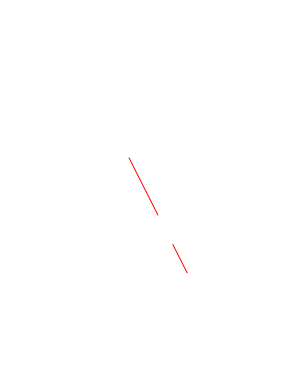

In [49]:
draw_strokes(sts, factor=20, c="red")